Lecture 6/Chapter 12 of BDA Quiz (96% of grade)


2. Stan warmup


In [1]:
if(!require(aaltobda)){
    install.packages("aaltobda", repos = c("https://avehtari.github.io/BDA_course_Aalto/", getOption("repos")))
    library(aaltobda)
}

Loading required package: aaltobda



In [2]:
if(!require(latex2exp)){
    install.packages("latex2exp")
    library(latex2exp)
}

Loading required package: latex2exp



In [3]:
if(!require(posterior)){
    install.packages("posterior")
    library(posterior)
}

Loading required package: posterior

This is posterior version 1.6.0


Attaching package: ‘posterior’


The following object is masked from ‘package:aaltobda’:

    mcse_quantile


The following objects are masked from ‘package:stats’:

    mad, sd, var


The following objects are masked from ‘package:base’:

    %in%, match




In [4]:
if(!require(ggplot2)){
    install.packages("ggplot2")
    library(ggplot2)
}

Loading required package: ggplot2



In [5]:
if(!require(bayesplot)){
    install.packages("bayesplot")
    library(bayesplot)
}

Loading required package: bayesplot

This is bayesplot version 1.11.1

- Online documentation and vignettes at mc-stan.org/bayesplot

- bayesplot theme set to bayesplot::theme_default()

   * Does _not_ affect other ggplot2 plots

   * See ?bayesplot_theme_set for details on theme setting


Attaching package: ‘bayesplot’


The following object is masked from ‘package:posterior’:

    rhat




In [6]:
if(!require(dplyr)){
    install.packages("dplyr")
    library(dplyr)
}

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [7]:
if(!require(tidyr)){
    install.packages("tidyr")
    library(tidyr)
}

Loading required package: tidyr



In [8]:
if(!require(cmdstanr)){
    install.packages("cmdstanr", repos = c("https://mc-stan.org/r-packages/", getOption("repos")))
    library(cmdstanr)
}

Loading required package: cmdstanr

CmdStan path set to: /coursedata/cmdstan/cmdstan-2.35.0

This is cmdstanr version 0.8.0

- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr

- CmdStan path: /coursedata/cmdstan/cmdstan-2.35.0

- CmdStan version: 2.35.0



In [9]:
cmdstan_installed <- function(){
  res <- try(out <- cmdstanr::cmdstan_path(), silent = TRUE)
  !inherits(res, "try-error")
}
if(!cmdstan_installed()){
    install_cmdstan()
}

In [10]:
# Check if cmdstanr is installed, install if not
if (!requireNamespace("cmdstanr", quietly = TRUE)) {
    install.packages("cmdstanr", repos = c("https://mc-stan.org/r-packages/", getOption("repos")))
}

# Load cmdstanr library
library(cmdstanr)

# Optional: Check if CmdStan is installed and get the path
cmdstan_path()  # This should return the path to your CmdStan installation


[1] "/coursedata/cmdstan/cmdstan-2.35.0"

In [13]:
# These are our observations y: the proportion of students handing in each assignment (1-8),
# sorted by year (row-wise) and assignment (column-wise).
# While the code suggest a matrix structure, 
# the result will actually be a vector of length N = no_years * no_assignments
propstudents<-c(c(176, 174, 158, 135, 138, 129, 126, 123)/176,
                c(242, 212, 184, 177, 174, 172, 163, 156)/242,
                c(332, 310, 278, 258, 243, 242, 226, 224)/332,
                c(301, 269, 231, 232, 217, 208, 193, 191)/301,
                c(245, 240, 228, 217, 206, 199, 191, 182)/245,
                c(264, 249, 215, 221, 215, 206, 192, 186)/264)
# These are our predictors x: for each observation, the corresponding assignment number.
assignment <- rep(1:8, 6)
# These are in some sense our test data: the proportion of students handing in the last assignment (9),
# sorted by year. 
# Usually, we would not want to split our data like that and instead
# use e.g. Leave-One-Out Cross-Validation (LOO-CV, see e.g. http://mc-stan.org/loo/index.html)
# to evaluate model performance.
propstudents9 = c(121/176, 153/242, 218/332, 190/301, 175/245, 179/264)
# The total number of assignments
no_assignments = 9
# The assignment numbers for which we want to generate predictions
x_predictions = 1:no_assignments
# (Cmd)Stan(R) expects the data to be passed in the below format:
model_data = list(N=length(assignment),
                 x=assignment,
                 y=propstudents,
                 no_predictions=no_assignments,
                 x_predictions=x_predictions)

In [14]:
# This reads the file at the specified path and tries to compile it. 
# If it fails, an error is thrown.
retention_model = cmdstan_model("assignment6_linear_model.stan")
# This "out <- capture.output(...)" construction suppresses output from cmdstanr
# See also https://github.com/stan-dev/cmdstanr/issues/646
out <- capture.output(
    # Sampling from the posterior distribution happens here:
    fit <- retention_model$sample(data=model_data, refresh=0, show_messages=FALSE)
)

error: error opening 'src/cmdstan/main_threads.d': Read-only file system
1 error generated.


error: unable to open output file 'stan/src/stan/model/model_header.hpp.gch/model_header_threads_14_0.hpp.gch': 'Read-only file system'
1 error generated.


Warning message:
“CmdStan's precompiled header (PCH) files may need to be rebuilt.
If your model failed to compile please run rebuild_cmdstan().
If the issue persists please open a bug report.”
make: *** [make/program:28: stan/src/stan/model/model_header.hpp.gch/model_header_threads_14_0.hpp.gch] Error 1


Warning message:
“CmdStan's precompiled header (PCH) files may need to be rebuilt.
If your model failed to compile please run rebuild_cmdstan().
If the issue persists please open a bug report.”


ERROR: Error: An error occured during compilation! See the message above for more information.


In [13]:
# This extracts the draws from the sampling result as a data.frame.
draws_df = fit$draws(format="draws_df")

# This does some data/draws wrangling to compute the 5, 50 and 95 percentiles of 
# the mean at the specified covariate values (x_predictions). 
# It can be instructive to play around with each of the data processing steps
# to find out what each step does, e.g. by removing parts from the back like "|>  gather(pct,y,-x)"
# and printing the resulting data.frame.
mu_quantiles_df = draws_df |> 
      subset_draws(variable = c("mu_pred")) |> 
      summarise_draws(~quantile2(.x, probs = c(0.05, .5, 0.95))) |> 
      mutate(x = 1:9) |> 
      pivot_longer(c(q5, q50, q95), names_to = c("pct"))
# Same as above, but for the predictions.
y_quantiles_df = draws_df |> 
      subset_draws(variable = c("y_pred")) |> 
      summarise_draws(~quantile2(.x, probs = c(0.05, .5, 0.95))) |> 
      mutate(x = 1:9) |> 
      pivot_longer(c(q5, q50, q95), names_to = c("pct"))

ERROR: Error: object 'fit' not found


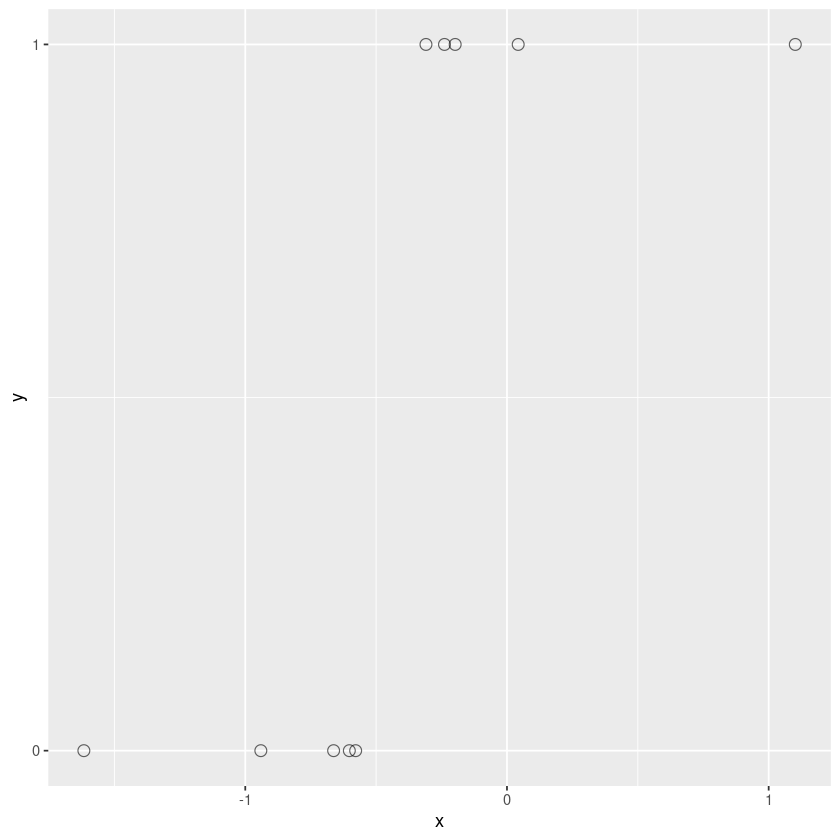

In [15]:
set.seed(48927+4)
M=1;
N=10;
x=matrix(sort(rnorm(N)),ncol=M)
y=rep(c(0,1), each=N/2)
data_logit <-list(M = M, N = N, x = x, y = y)
data.frame(data_logit) |>
  ggplot(aes(x, y)) +
  geom_point(size = 3, shape=1, alpha=0.6) +
  scale_y_continuous(breaks=c(0,1))


In [16]:
data_logit$diagnostic_summary()

ERROR: Error: attempt to apply non-function


In [17]:
model <- cmdstan_model("logistic_regression.stan")

ERROR: Error in initialize(...): Assertion on 'stan_file' failed: File does not exist: 'logistic_regression.stan'.
